# Porównanie 3 metod regresji na podstawie 3 różnych zbiorów danych: Jakość wina

W niniejszej pracy wykorzystuję metody:
- K najbliższych sąsiądów (KNN)
- Regresji liniowej
- Lasu losowego

Używam następujących zbiorów danych:
- [Wine Quality](https://www.kaggle.com/datasets/rajyellow46/wine-quality)
    - zmienna objaśniana: jakość wina

## Załadowanie potrzebnych bibliotek

In [37]:
import random
import os
from joblib import dump, load

import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np

import matplotlib.pyplot as plt

import sklearn
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import mlflow

%load_ext dotenv
%dotenv ../.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Stałe

In [8]:
random_state = 0

np.random.seed(random_state)
os.environ["PYTHONHASHSEED"] = str(random_state)
random.seed(random_state)

In [9]:
# if you want to log mlflow and you have the server configured change to True
want_to_log_mlflow = False

log_mlflow = "MLFLOW_TRACKING_URI" in os.environ and want_to_log_mlflow
if log_mlflow: mlflow.set_experiment("Wine_quality")

In [10]:
sklearn.set_config(transform_output="pandas")

In [84]:
plt.style.use("ggplot")

## Wczytanie danych

In [11]:
wine_quality = pd.read_csv("../data/winequalityN.csv")

### Krótka analiza eksploracyjna danych

In [12]:
## uncomment if you want to create an automated EDA report
# ProfileReport(dataset, title=f"Profiling Report for Wine quality dataset").to_file(f"../data/wine_quality_EDA.html")

## Preprocessing

In [13]:
wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [14]:
wine_quality.sample(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
5316,red,11.9,0.38,0.51,2.0,0.121,7.0,20.0,0.99960,3.24,0.76,10.4,6
5210,red,9.0,0.46,0.31,2.8,0.093,19.0,98.0,0.99815,3.32,0.63,9.5,6
3518,white,7.5,0.20,0.41,1.2,0.050,26.0,131.0,0.99133,3.19,0.52,11.1,5
1622,white,6.5,0.44,0.49,7.7,0.045,16.0,169.0,0.99570,3.11,0.37,8.7,6
2443,white,6.6,0.32,0.33,2.5,0.052,40.0,219.5,0.99316,3.15,0.60,10.0,5


In [15]:
wine_quality.isna().sum().sort_values(ascending=False)

fixed acidity           10
pH                       9
volatile acidity         8
sulphates                4
citric acid              3
residual sugar           2
chlorides                2
type                     0
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
alcohol                  0
quality                  0
dtype: int64

In [16]:
X = wine_quality.drop(columns=["quality"])
y = wine_quality["quality"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=random_state)

In [18]:
X_train.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [19]:
imputer = make_column_transformer((SimpleImputer(strategy="median"), make_column_selector(dtype_include=np.number)),
                                  remainder=SimpleImputer(strategy="most_frequent"), 
                                  n_jobs=-1, 
                                  verbose=True, 
                                  verbose_feature_names_out=False,
                                  )

In [20]:
encoder = make_column_transformer((OneHotEncoder(sparse_output=False), ["type"]), 
                                  remainder="passthrough",
                                  n_jobs=-1, 
                                  verbose=True, 
                                  verbose_feature_names_out=False,
                                  )


In [21]:
preprocessing_pipe = make_pipeline(imputer, encoder, verbose=True)
preprocessing_pipe

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(n_jobs=-1,
                                   remainder=SimpleImputer(strategy='most_frequent'),
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019406C1B460>)],
                                   verbose=True,
                                   verbose_feature_names_out=False)),
                ('columntransformer-2',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['type'])],
                                   verbose=True,
                                   verbose_feature_names_out=False))],
         verbose=True)

In [22]:
X_train_preprocessed = preprocessing_pipe.fit_transform(X_train)

[Pipeline]  (step 1 of 2) Processing columntransformer-1, total=   2.5s
[Pipeline]  (step 2 of 2) Processing columntransformer-2, total=   1.0s


# Modelowanie

In [23]:
knn_params = {"n_neighbors": [5, 25, 50],
                "weights": ["uniform", "distance"],
                "leaf_size": [20, 30, 50],
                "p": [1, 2],
                }

random_forest_params = {"n_estimators": [50, 100, 200],
                        "max_depth": [None, 3, 4, 5],
                        "max_features": [None, "sqrt", "log2"],
                        }

Przy wyczerpującym przeszukiwania siatki parametrów w celu znalezienia najlepszej kombinacji parametrów użyjemy walidacji krzyżowej.

[<img src="../img/grid_search_cross_validation.png" alt="drawing" width="400"/>]("../img/grid_search_cross_validation.png") \
źródło: https://scikit-learn.org/stable/modules/cross_validation.html

In [24]:
folds = KFold(n_splits=5, shuffle=True, random_state=random_state)

## Regresja liniowa

In [25]:
linreg = LinearRegression(n_jobs=-1)

In [26]:
linreg.fit(X_train_preprocessed, y_train)

LinearRegression(n_jobs=-1)

In [27]:
linreg.score(X_train_preprocessed, y_train)

0.2904916695297072

### K najbliższych sąsiadów

In [28]:
search_knn = GridSearchCV(estimator=KNeighborsRegressor(n_jobs=-1),
                   param_grid=knn_params,
                   scoring="r2",
                   n_jobs=-1,
                   refit=True,
                   cv=folds,
                   return_train_score=True,
                   verbose=3,
                   )

In [54]:
%%time
search_knn.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 391 ms
Wall time: 6.92 s


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 50], 'n_neighbors': [5, 25, 50],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='r2', verbose=3)

In [29]:
## uncomment if you want to save you model
# dump(search_knn, "../models/search_knn_wine_quality.joblib")
## uncomment if you want load a saved model
search_knn = load("../models/search_knn_wine_quality.joblib")

In [30]:
pd.DataFrame(search_knn.cv_results_);

### Las losowy

In [58]:
search_random_forest = GridSearchCV(estimator=RandomForestRegressor(random_state=random_state),
                                           param_grid=random_forest_params,
                                           scoring="r2",
                                           n_jobs=-1,
                                           refit=True,
                                           cv=folds,
                                           return_train_score=True,
                                         verbose=3,
                                        )

In [59]:
%%time
search_random_forest.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 5.53 s
Wall time: 1min 48s


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='r2', verbose=3)

In [31]:
## uncomment if you want to save you model
# dump(search_random_forest, "../models/search_random_forest_wine_quality.joblib")
## uncomment if you want load a saved model
search_random_forest = load("../models/search_random_forest_wine_quality.joblib")

In [32]:
pd.DataFrame(search_random_forest.cv_results_);

## Analiza

Na tym tym posiadam już dostrojone, finalne modele. Teraz zostaną one porównane wg następujących metryk:

- MAE
- MSE
- MAPE
- RMSE
- R2

In [33]:
final_models = [("linear_regression", linreg), ("knn", search_knn.best_estimator_), ("random_forest", search_random_forest.best_estimator_)]

In [34]:
rows = []

for model_name, model in final_models:
    params = search_random_forest.best_estimator_.get_params()
    
    y_pred = model.predict(preprocessing_pipe.transform(X_test))
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    metrics = {"mae": mae, "mse": mse, "mape": mape, "rmse": rmse, "r2": r2}
    rows.append(metrics)

    if log_mlflow:
        with mlflow.start_run(run_name=model_name) as run:
            mlflow.log_params(params)
        
            mlflow.log_metrics(metrics)
            
            model_info = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="wine_quality",
                input_example=X_test,
            )

In [35]:
results = pd.DataFrame(rows, index=[tpl[0] for tpl in final_models])

In [36]:
results.style.format(precision=2, thousands=",")

,mae,mse,mape,rmse,r2
linear_regression,0.57,0.52,0.10,0.72,0.35
knn,0.45,0.46,0.08,0.68,0.42
random_forest,0.41,0.32,0.07,0.57,0.60


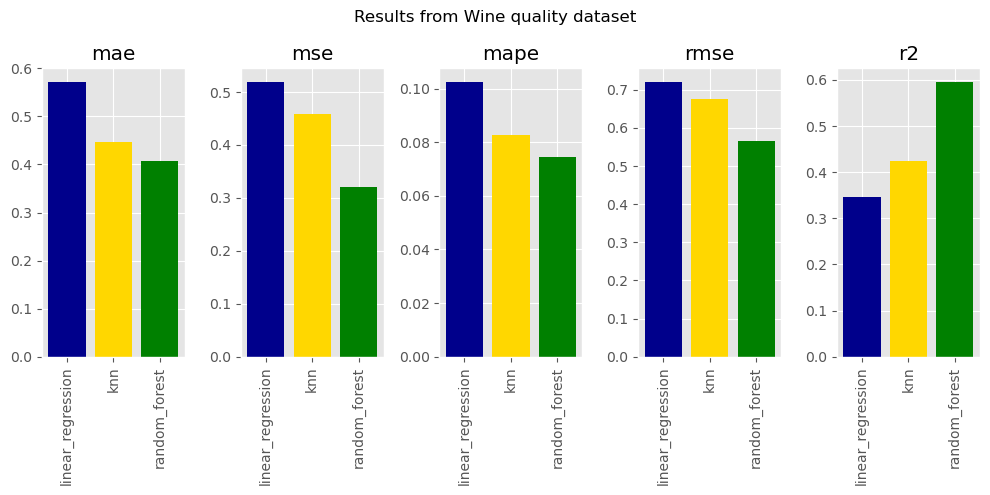

In [89]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
colors = ["darkblue", "gold", "green"]

metrics = results.columns
for i, metric in enumerate(metrics):
    axes[i].bar(results.index, results[metric], color=colors)
    axes[i].set_title(metric)
    axes[i].xaxis.set_ticks([0, 1, 2], results.index, rotation=90)

fig.suptitle("Results from Wine quality dataset")
plt.tight_layout()
plt.show()
